In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

%matplotlib inline

Напишем класс, реализующий линейную регрессию и ее статистические свойства в условиях **гомоскедастичности**.

In [ ]:
class LinearRegression:
    '''
    Класс, реализующий линейную регрессию c помощью МНК.
    '''

    def __init__(self, fit_intercept=True, alpha=0.05):
        '''
        :param fit_intercept: добавлять ли смещение(константный признак)
        :param alpha: уровень значимости критерия,
                      (1-alpha): уровень доверия дов. интервала
        '''
        self.fit_intercept = fit_intercept
        self.alpha = alpha


    def fit(self, X, Y):
        '''
        Функция обучения модели.

        Предполагается модель Y = X * theta + epsilon,
        где epsilon имеет норм. распр. с параметрами (0, sigma^2 * I_n).

        :param X: регрессор (матрица размера n x d),
        :param Y: отклик (матрица размера n x 1),
        '''

        # При необходимости добавьте константу, используйте self.fit_intercept
        if self.fit_intercept:
            X_with_constant = np.hstack((np.ones((X.shape[0], 1)), X))
            X = X_with_constant

        self.n, self.d = X.shape
        # МНК-оценка
        self.x_transpose_x = np.matrix(X.T @ X)
        self.theta = np.array(self.x_transpose_x.I) @ X.T @ Y
        # несмещенная оценка для sigma^2
        self.sigma_sq = ((Y - X @ self.theta) ** 2).sum() / (self.n - self.d)

        # вспомогательные величины для подсчетов
        root = np.sqrt(
            np.diag(np.array(np.matrix(X.T @ X).I)) * self.sigma_sq
        ).reshape(-1, 1)
        quantile = sps.t(df=self.n-self.d).ppf(1 - self.alpha/ 2)

        # доверительные интервалы для коэффициентов
        self.conf_int = np.concatenate((
            [self.theta - root * quantile, self.theta + root * quantile]),
            axis=1
        )

        # статистики критериев о незначимости коэффициентов
        self.t_stats = self.theta / root
        self.t_pvalue = 2*sps.t(df=self.n-self.d).sf(np.abs(self.t_stats))

        # статистика критерия о незначимости регрессии
        R_square = 1 - ((Y - X @ self.theta) ** 2).sum() / ((Y - Y.mean()) ** 2).sum()
        self.f_stat = R_square * (self.d - 1) / ((1 - R_square) * (self.n - self.d))
        self.f_pvalue = sps.f(dfd=self.d - 1, dfn=self.n - self.d).sf(self.f_stat)

        return self


    def summary(self, names=None):
        '''
        Печатает таблицу с информацией для каждого коэффициента,
        в которой указана его оценка, границы дов. интервала,
        статистика критерия и значение p-value
        '''

        print(f'Линейная регрессия на {self.d} признаках и {self.n} объектах')
        print(f'Sigma: {self.sigma_sq:.6f}')

        # Напечатайте результаты f-теста
        print('\tF-stat\t\tp-value')
        print('\t%.6f\t%.6f' % (self.f_stat, self.f_pvalue))

        # Далее напечатайте таблицу,
        # в которой для каждого коэффициента (по строкам)
        # будут следующие столбцы:
        # оценка, границы дов. интервала (два столбца),
        # статистика критерия, p-value
        columns = ['Левая граница', 'Оценка', 'Верхняя граница', 'T-stat', 'p-value']
        names = [f"theta_{i}" for i in np.arange(self.d)] if names is None else names
        values = []
        for j in range(self.d):
            values.append([
                self.conf_int[j, 0], self.theta[j, 0], self.conf_int[j, 1],
                self.t_stats[j, 0], self.t_pvalue[j, 0]
            ])
        display(pd.DataFrame(values, index=names, columns=columns))


    def predict(self, X, type_interval=None):
        '''
        Возвращает предсказание отклика на новых объектах X
        и опционально доверительный/предсказательный интервал.

        :param X: матрица объектов размера n x d
        :param type_interval: тип дов. интервала.
            Для этого параметра возможны три варианта:
            * None - возвратить только предсказание,
                    размер return-a: n;
            * 'confidence' - возвратить предсказание и
                доверительный интервал для среднего отклика,
                размер return-a: n x 3;
            * 'prediction' - возвратить предсказание и
                предсказательный интервал для новых объектов,
                размер return-a: n x 3.

        :return y_pred: предсказание/предсказание и дов./предсказ. инт.

        '''

        X = np.asarray(X)
        # при необходимости добавим контсанту
        if self.fit_intercept:
            X_with_constant = np.hstack((np.ones((X.shape[0], 1)), X))
            X = X_with_constant

        # получим предсказание
        y_pred = X @ self.theta

        if type_interval is None:
            return y_pred

        else:
            # квантиль распр. Стьюдента
            quantile = sps.t(df=self.n-self.d).ppf(1 - self.alpha/ 2)
            # добавляем 1, если это предсказательный интервал
            pred_addition = int(type_interval == 'prediction')

            # подсчет выражения под корнем
            root = np.sqrt((
                pred_addition + np.diag(X @ self.x_transpose_x.I @ X.T).reshape(-1, 1)
            ) * self.sigma_sq)

            # строим интервал
            left = y_pred - quantile * root
            right = y_pred + quantile * root
            interval = (left, right)
            return y_pred, interval

Применим написанный класс для реальных данных и напечатаем `summary`. Предварительно разделим данные на обучающую и тестовую части, а также выполним необходимые преобразования признаков.

In [ ]:
bikes = pd.read_csv("bike_sharing_dataset/day.csv", index_col=0)
bikes.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


Будем работать только со следующими признаками:
* `season`: время года: 1 &mdash; весна, 2 &mdash; лето, 3 &mdash; осень, 4 &mdash; зима;
* `mnth`: месяц от 1 до 12;
* `holiday`: является ли текущий день праздничным;
* `weekday`: день недели от 0 до 6;
* `workingday`: является ли текущий день рабочим или выходным;
* `weathersit`: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман);
* `temp`: температура в Цельсиях;
* `atemp`: температура по ощущениям в Цельсиях;
* `hum`: влажность воздуха;
* `windspeed`: скорость ветра;
* `cnt`: количество арендованных велосипедов в текущий день.

In [ ]:
bikes = bikes.drop(["dteday", "yr", "casual", "registered"], axis=1)
bikes.head()

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
instant,,,,,,,,,,,
1,1,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
2,1,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
3,1,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
4,1,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
5,1,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


Разделим на обучающую и тестовую выборки

In [ ]:
train, test = train_test_split(bikes, test_size=0.1, random_state=19)

Обучим модель

In [ ]:
lm = LinearRegression()
lm.fit(train.drop(["cnt"], axis=1).values, train["cnt"].values.reshape(-1, 1))
lm.summary(['Intercept'] + train.columns[:-1].tolist())

Линейная регрессия на 11 признаках и 657 объектах
Sigma: 1774643.040895
	F-stat		p-value
	0.017515	1.000000


,Левая граница,Оценка,Верхняя граница,T-stat,p-value
Intercept,2262.303789,3000.353354,3738.402919,7.982693,6.558773e-15
season,314.259046,489.841114,665.423182,5.478197,6.161923e-08
mnth,-85.805488,-31.055047,23.695394,-1.113800,2.657794e-01
holiday,-1141.067928,-523.007963,95.052002,-1.661653,9.706762e-02
weekday,8.947477,60.068503,111.189528,2.307330,2.135168e-02
workingday,-125.424740,100.467391,326.359522,0.873346,3.827988e-01
weathersit,-726.143813,-481.880795,-237.617776,-3.873865,1.180416e-04
temp,-1767.154775,2520.654225,6808.463224,1.154358,2.487804e-01
atemp,-1408.540028,3457.220290,8322.980607,1.395208,1.634327e-01
hum,-3109.878488,-2138.815494,-1167.752499,-4.325023,1.766422e-05


Для объектов из тестовой части построим
* точечные предсказания,
* доверительный интервал для среднего таргета,
* предсказательный интервал для таргета.

Посчитаем, насколько часто истинное значения таргета попадают в построенные интервалы. Можно ли как-то проинтерпретировать это число?

In [ ]:
pred = lm.predict(test.values[:, :-1])
_, conf_int = lm.predict(test.values[:, :-1], type_interval="confidence")
_, pred_int = lm.predict(test.values[:, :-1], type_interval="prediction")

pd.DataFrame({
    "Истинное": test["cnt"].values.reshape(-1),
    "Предсказание" : pred.reshape(-1),
    "Confidence, left": conf_int[0].reshape(-1),
    "Confidence, right": conf_int[1].reshape(-1),
    "Prediction, left": pred_int[0].reshape(-1),
    "Prediction, right": pred_int[1].reshape(-1)
})

,Истинное,Предсказание,"Confidence, left","Confidence, right","Prediction, left","Prediction, right"
0,2133,3620.615400,3325.209256,3916.021543,988.107095,6253.123704
1,7639,5500.679234,5275.331169,5726.027300,2875.109404,8126.249064
2,4862,3721.687320,3487.082202,3956.292438,1095.306779,6348.067860
3,7359,5121.720532,4894.170783,5349.270281,2495.960819,7747.480245
4,4352,4667.597046,4404.788481,4930.405611,2038.547118,7296.646974
...,...,...,...,...,...,...
69,5698,4543.253077,4298.661268,4787.844885,1915.961632,7170.544521
70,7006,5993.393874,5755.235327,6231.552421,3366.693534,8620.094214
71,5585,4555.213229,4199.506763,4910.919695,1915.258254,7195.168204
72,4916,3307.932306,3023.140519,3592.724093,676.593950,5939.270662


Посмотрим насколько часто истинное значение попадает в интервалы

Предсказательный.

In [ ]:
((test["cnt"].values > pred_int[0].reshape(-1)) &
 (test["cnt"].values < pred_int[1].reshape(-1))).mean()

0.9459459459459459

Доверительный.

In [ ]:
((test["cnt"].values > conf_int[0].reshape(-1)) &
 (test["cnt"].values < conf_int[1].reshape(-1))).mean()

0.0945945945945946

**Выводы:**

Как мы видим, предсказательный интервал гораздо шире доверительного и сами предсказания чаще в него попадают. Также с помощью t-test и f-test можно проверить значимость коэффициентов и регрессии в целом. В задаче с велосипедами можно заметить, что не смотря на значимость отдельных коэффициентов, гипотеза о значимости регрессии не отвергается, а значит наша модель плохо справляется с предсказаниями. В данном случае необходима дополнительная предобработка данных, и отбор признаков для более точной модели.

Выберем один вещественный признак, для которого отвергается гипотеза о незначимости. Построим еще раз модель, используя только этот признак, а также константный признак. Нарисуем график, на котором отметим
* точки выборки,
* точечные предсказания,
* доверительный и предсказательный интервалы.

Обучим модель на признаке `windspeed` и на константе.

In [ ]:
lm = LinearRegression()
lm.fit(train[['windspeed']], train["cnt"].values.reshape(-1, 1))
lm.summary(['Intercept', 'windspeed'])

Линейная регрессия на 2 признаках и 657 объектах
Sigma: 3521618.207476
	F-stat		p-value
	0.000091	1.000000


,Левая граница,Оценка,Верхняя граница,T-stat,p-value
Intercept,5247.754216,5630.938042,6014.121868,28.855255,8.841022e-119
windspeed,-7866.838480,-5982.580470,-4098.322460,-6.234470,8.123029e-10


Предскажем и посчитаем доверительный и предсказательный интервалы.

In [ ]:
feature = np.sort(test[['windspeed']], axis=0)
pred = lm.predict(feature)
_, conf_int = lm.predict(feature, type_interval="confidence")
_, pred_int = lm.predict(feature, type_interval="prediction")

Визуализируем все, что нужно.

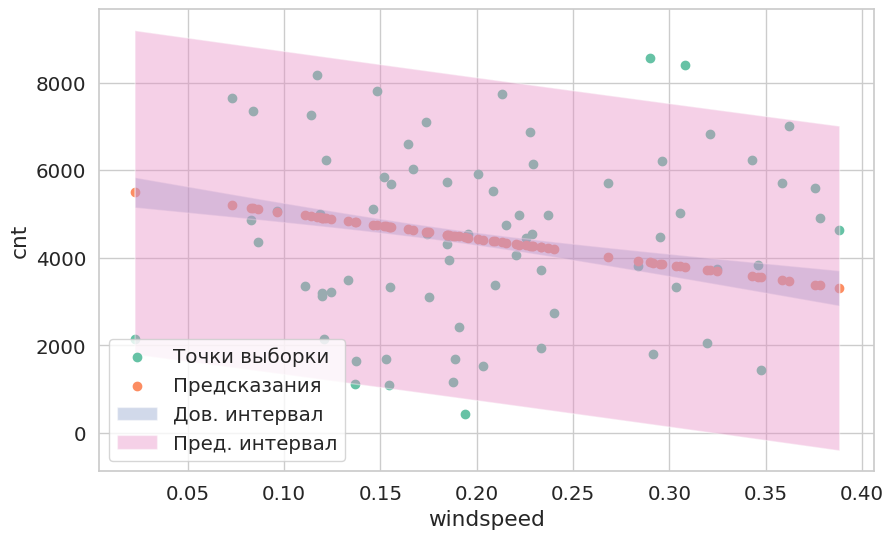

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(feature.reshape(-1), test['cnt'], label='Точки выборки')
plt.scatter(feature.reshape(-1), pred, label='Предсказания')
plt.fill_between(feature.reshape(-1), conf_int[0].reshape(-1), conf_int[1].reshape(-1), alpha=0.4, label='Дов. интервал')
plt.fill_between(feature.reshape(-1), pred_int[0].reshape(-1), pred_int[1].reshape(-1), alpha=0.4, label='Пред. интервал')
plt.xlabel('windspeed')
plt.ylabel('cnt')
plt.legend();

**Выводы:**

Как мы видим, предсказательный интервал гораздо шире доверительного и сами предсказания чаще в него попадают. Конечно, линейная зависимость эти данные описывает довольно плохо, но предсказательный интервал, кажется, действительно покрывает примерно 95% выборки.

---
---
---
---
---
---
---
---
---

Рассмотрим два признака $x_1, x_2$ и целевую метку $y$.
Будем предполагать зависимость $y(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_2$.
Для проверки гипотезы о *не*значимости признака $x_2$, то есть $\mathsf{H}_0\colon \theta_2=0$, на практике широко используется $T$-критерий (например, в AB-тестировании), который мы получили в предположениях гауссовской линейной модели. Проведем его исследования.

**1.** Оценим вероятность ошибки I рода в предположениях гауссовской линейной модели, в частности, **при наличии гомоскедастичности**. Для этого повторим достаточное количество раз следующую процедуру и усредним результаты.
1. Сгенерируем некоторым образом выборку размера 200 из признаков $x_1$ и $x_2$.
2. Сгенерируем целевую метку в предположениях гауссовской линейной модели. В процедуре оценки вероятности ошибки I рода на данном этапе необходимо брать $\theta_2 = 0$, то есть генерировать данные при справедливости $\mathsf{H}_0$.
3. Применим критерий.
4. Проведя достаточное количество шагов 1-3, сделаем оценку вероятности ошибки I рода и построим соответствующий доверительный интервал.

**T-test** для проверки гипотезы о незначимости признака $j$

$$T_0 = \cfrac{\widehat{\theta}_j}{\widehat{\sigma}\sqrt{(X^T X)^{-1}_{jj}}} \sim T_{n-d}$$

**F-test** для проверки гипотезы о незначимости группы признаков $\{x_2\}$, состоящей из одного признака

$$F_0 = \cfrac{RSS(\widehat{\theta}_{01}) - RSS(\widehat{\theta})}{RSS(\widehat{\theta})} \cdot (n-d) \sim F_{1, n-d}$$

**Обобщенный F-test** для проверки линейной гипотезы $\mathsf{H}_0\colon \theta_j=0$.

$$F_0 = \cfrac{\widehat{\theta}_j^T(X^T X)^{-1}_{jj}\widehat{\theta}_j}{RSS(\widehat{\theta})} \cdot (n-d) \sim F_{1, n-d}$$

In [ ]:
def RSS(theta, Y, X):
    return np.power(Y - X@theta, 2).sum(axis=1)


def generate_data(
    theta_0, theta_1, theta_2=0,
    x1_distr=sps.laplace, x2_distr=sps.uniform,
    sample_size=200, sample_count=int(1e4),
    noise=sps.norm, heteroscedasticity_feature_index=0
):
    '''
    Генерация данных в модели y(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_2.

    theta_0, theta_1, theta_2 - базовые параметры модели
    sample_size - размер одной выборки
    sample_count - количество выборок
    noise - распределение шума
    heteroscedasticity_feature_index - индекс признака для гетероскедастичности

    Возвращает:
    X - матрица признаков размера (sample_count, sample_size, 3)
    Y - целевая метрика размера (sample_count, sample_size, len(theta_2))

    k-ая выборка для m-го параметра сетки получается как
    Y[k, :, m] = X[k] @ [theta_0, theta_1, theta_2[m]]^T + noise
    '''

    theta = np.array([theta_0, theta_1, theta_2]).reshape((-1, 1))

    x1 = x1_distr.rvs(size=(sample_count, sample_size))
    x2 = x2_distr.rvs(size=(sample_count, sample_size))
    X = np.stack([np.ones((sample_count, sample_size)), x1, x2], axis=-1)

    Y = X @ theta

    for hfi in heteroscedasticity_feature_index:
        Y += noise.rvs(size=(Y.shape)) * X[:,:, hfi:hfi+1]

    return X, Y


def experiment(
    theta_0, theta_1, theta_2_vals=[0],
    x1_distr=sps.laplace, x2_distr=sps.uniform, alpha=0.05,
    sample_size=200, sample_count=int(1e4),
    noise=sps.norm, heteroscedasticity_feature_index=[0]
):
    '''
    Реализация эксперимента: генерация данных и проверка трех критериев.

    theta_0, theta_1 - параметры истинного отклика
    theta_2_vals - исследуемый параметр модели, может быть задан сеткой
    alpha - ур.значимости
    sample_size - размер выборки
    sample_count - количество выборок
    noise - распределение шума
    heteroscedasticity_feature_index - индексы признаков для гетероскедастичности

    Возвращает:
    t_res, - маски отвержения гипотезы о незначимости признака x_2
    в виде матриц размера (sample_count, len(t2))
    '''

    t_res = []

    progress_line = tqdm if len(theta_2_vals) > 1 else (lambda x: x)
    for theta_2 in progress_line(theta_2_vals):
        # Генерируем sample_size наборов данных
        X, Y = generate_data(
            theta_0, theta_1, theta_2, x1_distr, x2_distr, sample_size, sample_count,
            noise, heteroscedasticity_feature_index
        )

        # МНК-оценка коэффициентов
        XX_inv = np.linalg.inv(np.transpose(X, (0, 2, 1)) @ X)
        theta_hat = XX_inv @ np.transpose(X, (0, 2, 1)) @ Y

        # Несмещенная оценка дисперсии
        sigma_hat = np.sqrt(RSS(theta_hat, Y, X) / (sample_size-3))

        # T-test
        t_stat = theta_hat[:,2,:] / (sigma_hat * np.sqrt(XX_inv[:,2,2]).reshape(-1, 1))
        t_res.append(np.abs(t_stat) > sps.t.ppf(1 - alpha/2, df=sample_size-3))

    t_res = np.concatenate(t_res, axis=-1)
    return t_res


def conf_int(sample, alpha=0.95):
    means = sample.mean(axis=0)
    diffs = sps.norm.ppf((1+alpha)/2) * np.sqrt(means*(1-means)/sample.shape[0])
    return means - diffs, means + diffs


def table(results):
    left, right = conf_int(results)
    print(f"P(I) conf. int.: ({left[0]:.3}, {right[0]:.3})")


def draw_conf(x, intervals, labels, new_figure=True):
    '''
    Функция отрисовывающая доверительные ленты
    '''

    colors = sns.color_palette('Set2', n_colors=len(intervals))

    if new_figure:
        plt.figure(figsize=(12, 6))

    for interval, label, color in zip(intervals, labels, colors):
        plt.fill_between(
            x, interval[0], interval[1],
            alpha=0.8, color=color, label=label
        )

    plt.legend()
    plt.xlabel(r"Параметр $\theta_2$")
    plt.ylabel("Мощность")

*Гомоскедастичность, стандартный шум*

In [ ]:
table(experiment(1, 2))

P(I) conf. int.: (0.0475, 0.0561)


Результаты могут сильно зависеть от того, как были сгенерированы данные для эксперимента. Для надежности повторим эксперимент, как-либо иначе сгенерировав признаки. Например, для генерации можно взять другое распределение признаков.

In [ ]:
table(experiment(1, 2, x1_distr=sps.norm, x2_distr=sps.expon))

P(I) conf. int.: (0.0458, 0.0544)


In [ ]:
table(experiment(1, 2, x1_distr=sps.norm, x2_distr=sps.laplace))

P(I) conf. int.: (0.0446, 0.053)


**2.** Повторим проведенные эксперименты **для случая гетероскедастичности**. Для этого сгенерируйте $\varepsilon_i$ из нормального распределения с дисперсией, зависящей от признаков. Например, в случае неотрицательных признаков можно взять $\mathsf{D} \varepsilon_i = \psi_0 + \psi_1 x_{i1} + \psi_2 x_{i2}$ для некоторых коэффициентов $\psi_j$.

В частности, исследуем случаи
* $\psi_1\not=0, \psi_2=0$;
* $\psi_1=0, \psi_2\not=0$;
* $\psi_1\not=0, \psi_2\not=0$;

In [ ]:
for hfi_arr in [[1], [2], [1, 2]]:
    print(F'Гетероскедастичность по признакам: {hfi_arr}')
    table(experiment(1, 2, heteroscedasticity_feature_index=hfi_arr))

Гетероскедастичность по признакам: [1]
P(I) conf. int.: (0.0479, 0.0567)
Гетероскедастичность по признакам: [2]
P(I) conf. int.: (0.0738, 0.0844)
Гетероскедастичность по признакам: [1, 2]
P(I) conf. int.: (0.05, 0.0588)


In [ ]:
for hfi_arr in [[1], [2], [1, 2]]:
    print(F'Гетероскедастичность по признакам: {hfi_arr}')
    table(experiment(1, 2, heteroscedasticity_feature_index=hfi_arr, x2_distr=sps.laplace))

Гетероскедастичность по признакам: [1]
P(I) conf. int.: (0.0494, 0.0582)
Гетероскедастичность по признакам: [2]
P(I) conf. int.: (0.398, 0.417)
Гетероскедастичность по признакам: [1, 2]
P(I) conf. int.: (0.272, 0.29)


In [ ]:
for hfi_arr in [[1], [2], [1, 2]]:
    print(F'Гетероскедастичность по признакам: {hfi_arr}')
    table(experiment(1, 2, heteroscedasticity_feature_index=hfi_arr, x2_distr=sps.cauchy))

Гетероскедастичность по признакам: [1]
P(I) conf. int.: (0.0527, 0.0619)
Гетероскедастичность по признакам: [2]
P(I) conf. int.: (0.883, 0.895)
Гетероскедастичность по признакам: [1, 2]
P(I) conf. int.: (0.873, 0.886)


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

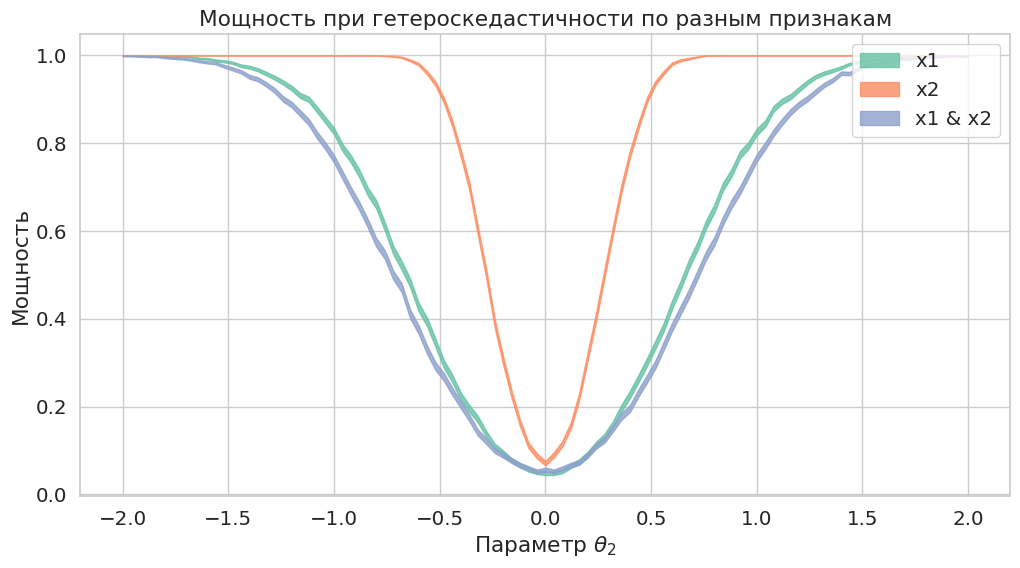

In [ ]:
t_grid=np.linspace(-2, 2, 101)
t_res_int = [
    conf_int(experiment(1, 2, t_grid, heteroscedasticity_feature_index=hfi_arr))
    for hfi_arr in [[1], [2], [1, 2]]
]


draw_conf(t_grid, t_res_int, ['x1', 'x2', 'x1 & x2'])
plt.title('Мощность при гетероскедастичности по разным признакам');

В этом случае ошибка первого рода не контролируется при отсутствии гетероскедастичности по $x_2$. Возможно, поэтому более мощный критерий получается в случае отсутствия гетероскедастичности по $x_2$.

**3.** Исследуем, как меняется вероятность ошибки I рода при отклонении распределения шума от нормальности. В качестве распределения шума возьмем **распределение Стьюдента** с 1, 3, 5, 10 степенями свободы. Шум должен быть **гомоскедастичным**.

In [ ]:
df_arr = [1, 3, 5, 10]
for df in df_arr:
    print(f'df = {df}')
    table(experiment(1, 2, noise=sps.t(df=df)))
    print('*' * 50)

df = 1
P(I) conf. int.: (0.0315, 0.0387)
**************************************************
df = 3
P(I) conf. int.: (0.0447, 0.0531)
**************************************************
df = 5
P(I) conf. int.: (0.0439, 0.0523)
**************************************************
df = 10
P(I) conf. int.: (0.0455, 0.0541)
**************************************************


**Вывод:** при шуме из распределения Коши (1 степень свободы) критерий занижает уровень значимости, что может отразиться на мощности. При всех остальных, кажется, все нормально.

**4.** Оценим и визуализируем мощность критерия в зависимости от истинного значения $\theta_2$. Для сравнения будем использовать гомоскедастичный шум из нормального распределения и распределения Стьюдента с рассмотренными ранее значениями степени свободы.

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

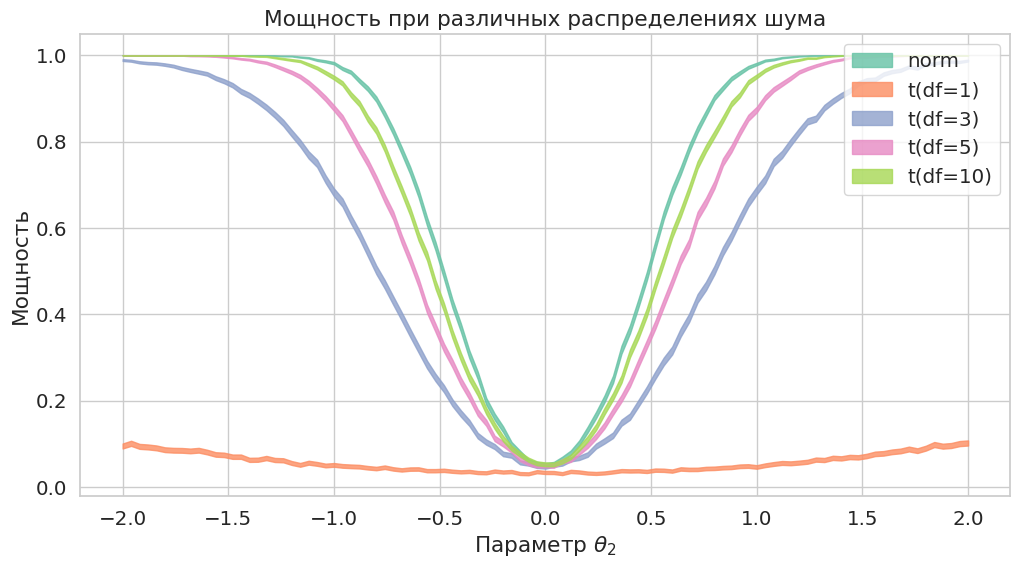

In [ ]:
t_grid=np.linspace(-2, 2, 101)
t_res_int = [
    conf_int(experiment(1, 2, t_grid))]

df_arr = [1, 3, 5, 10]
t_res_int += [
    conf_int(experiment(1, 2, t_grid, noise=sps.t(df=df)))
    for df in df_arr
]

draw_conf(t_grid, t_res_int, ['norm', 't(df=1)', 't(df=3)', 't(df=5)', 't(df=10)',])
plt.title('Мощность при различных распределениях шума');

**Вывод:** действительно видим, что мощность при шуме из распределения Коши сильно страдает. При остальных распределениях Стьюдента мощность немного меньше чем при нормальном шуме. С ростом степеней свободы мощность приближается к мощности при нормальном шуме.